## LOGISTIC REGRESSION PART II

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import seaborn as sns

# Load the cleaned csv file
df = pd.read_csv("data\\Airline_customer_satisfaction_cleaned.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129487 entries, 0 to 129486
Data columns (total 22 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       129487 non-null  int64  
 1   Customer Type                      129487 non-null  object 
 2   Age                                129487 non-null  int64  
 3   Type of Travel                     129487 non-null  object 
 4   Class                              129487 non-null  object 
 5   Flight Distance                    129487 non-null  int64  
 6   Seat comfort                       129487 non-null  int64  
 7   Departure/Arrival time convenient  129487 non-null  int64  
 8   Food and drink                     129487 non-null  int64  
 9   Gate location                      129487 non-null  int64  
 10  Inflight wifi service              129487 non-null  int64  
 11  Inflight entertainment             1294

I know now which features are actually numerical or rather categorical, so I will split them first

In [4]:
# make subsets on the actual type

df_num =df[['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']]
df_cat = df[['Class', 'Type of Travel', 'Customer Type', 'satisfaction', 'Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 'Gate location', 'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']]

Let's visualise these "fake categories" against the target variable.

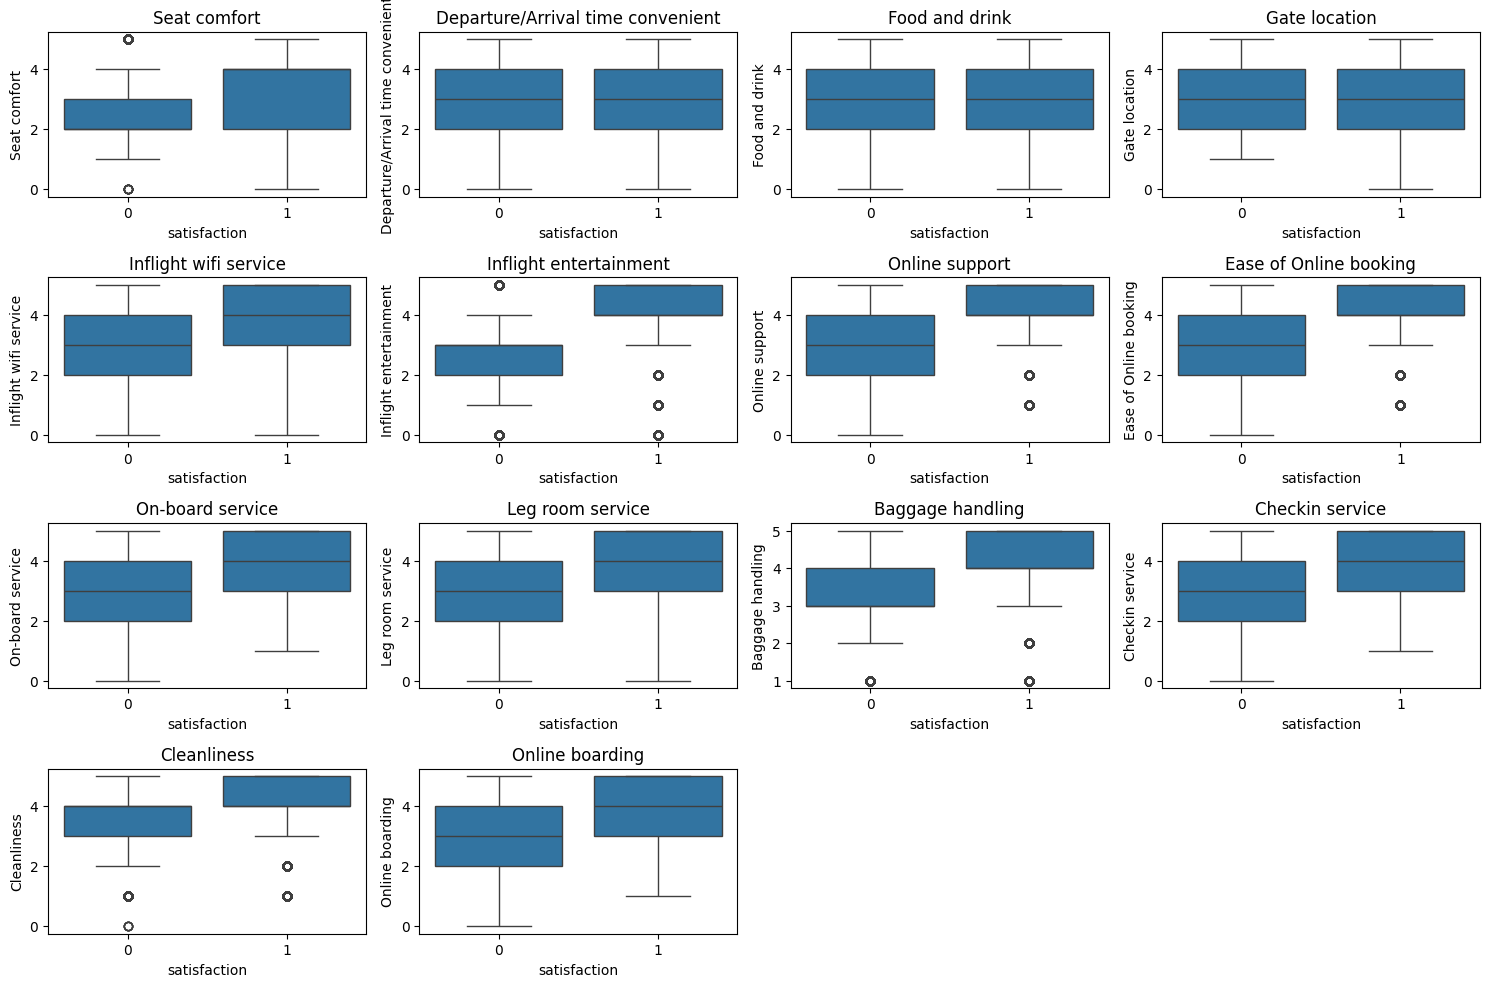

In [5]:
cols = ["Seat comfort", "Departure/Arrival time convenient", "Food and drink", 
        "Gate location", "Inflight wifi service", "Inflight entertainment", 
        "Online support", "Ease of Online booking", "On-board service", 
        "Leg room service", "Baggage handling", "Checkin service", 
        "Cleanliness", "Online boarding"]

plt.figure(figsize=(15, 12))

for i, col in enumerate(cols, 1):
    plt.subplot(5, 4, i) 
    sns.boxplot(x=df["satisfaction"], y=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()


Departure/Arrival time convenient, Food and drink, and Gate location look like they have almost no impact. 

In [6]:
df_cat[['Departure/Arrival time convenient', 'Food and drink', 'Gate location']].corrwith(df['satisfaction'])

Departure/Arrival time convenient   -0.015624
Food and drink                       0.120568
Gate location                       -0.012272
dtype: float64

That's almost nothing, I will drop them.

In [7]:
df_cat = df_cat.copy() 
df_cat.drop(['Departure/Arrival time convenient', 'Food and drink', 'Gate location'], axis=1, inplace=True)


Now for the "real categorical" ones

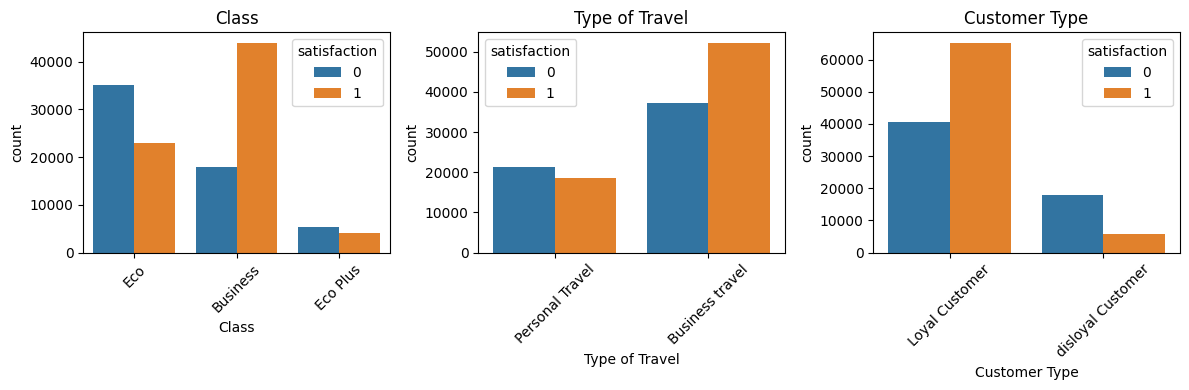

In [8]:
plt.figure(figsize=(12, 4))

for i, col in enumerate(["Class", "Type of Travel", "Customer Type"], 1):
    plt.subplot(1, 3, i)
    sns.countplot(x=df[col], hue=df["satisfaction"])
    plt.title(col)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [9]:
from sklearn.preprocessing import LabelEncoder

df_temp = df[['Class', 'Type of Travel', 'Customer Type']].copy()
encoder = LabelEncoder()

for col in df_temp.columns:
    df_temp[col] = encoder.fit_transform(df_temp[col])

df_temp.corrwith(df['satisfaction'])


Class            -0.278937
Type of Travel   -0.108910
Customer Type    -0.292563
dtype: float64

Too much correlation to drop those. Let's see a correlation now between them all.

In [10]:
df_cat = df_cat.drop(columns=['Class', 'Type of Travel', 'Customer Type'])
df_combined = pd.concat([df_temp, df_cat], axis=1)


In [11]:
df_combined = pd.concat([df_temp, df_cat], axis=1)

correlation_list = df_combined.corrwith(df['satisfaction']).sort_values(ascending=False)
correlation_list

satisfaction              1.000000
Inflight entertainment    0.523364
Ease of Online booking    0.432017
Online support            0.389890
On-board service          0.352283
Online boarding           0.338118
Leg room service          0.305115
Checkin service           0.266089
Baggage handling          0.260398
Cleanliness               0.259504
Seat comfort              0.242371
Inflight wifi service     0.227010
Type of Travel           -0.108910
Class                    -0.278937
Customer Type            -0.292563
dtype: float64

Will also drop Type of Travel, doesn't have too much correlation. But I have to be carefull, because I encoded it temporary, so will have to leave it out of that one and combine again.

In [12]:
df_temp = df_temp.drop(columns=['Type of Travel'])
df_combined = pd.concat([df_temp, df_cat], axis=1)


Check again with the rest.

In [13]:
correlation_list = df_combined.corrwith(df['satisfaction']).sort_values(ascending=False)
correlation_list

satisfaction              1.000000
Inflight entertainment    0.523364
Ease of Online booking    0.432017
Online support            0.389890
On-board service          0.352283
Online boarding           0.338118
Leg room service          0.305115
Checkin service           0.266089
Baggage handling          0.260398
Cleanliness               0.259504
Seat comfort              0.242371
Inflight wifi service     0.227010
Class                    -0.278937
Customer Type            -0.292563
dtype: float64

Let's check them between eachother for colinearity

In [14]:
corr_matrix = df_combined.corr().abs()

high_corr = corr_matrix.unstack().sort_values(ascending=False)
high_corr = high_corr[high_corr < 1] 
high_corr = high_corr[high_corr > 0.8]

print(high_corr)

Series([], dtype: float64)


This is clear, we will use those "categorical" ones. Now first checking if if I'm going to scale the numeric ones.

In [15]:
df_num.describe()

,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes
count,129487.000000,129487.000000,129487.000000,129487.000000
mean,39.428761,1981.008974,14.643385,15.091129
std,15.117597,1026.884131,37.932867,38.465650
min,7.000000,50.000000,0.000000,0.000000
25%,27.000000,1359.000000,0.000000,0.000000
50%,40.000000,1924.000000,0.000000,0.000000
75%,51.000000,2543.000000,12.000000,13.000000
max,85.000000,6951.000000,1592.000000,1584.000000


In [16]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129487 entries, 0 to 129486
Data columns (total 4 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Age                         129487 non-null  int64  
 1   Flight Distance             129487 non-null  int64  
 2   Departure Delay in Minutes  129487 non-null  int64  
 3   Arrival Delay in Minutes    129487 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 4.0 MB


In [17]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129487 entries, 0 to 129486
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   Class          129487 non-null  int64
 1   Customer Type  129487 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [18]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129487 entries, 0 to 129486
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   satisfaction            129487 non-null  int64
 1   Seat comfort            129487 non-null  int64
 2   Inflight wifi service   129487 non-null  int64
 3   Inflight entertainment  129487 non-null  int64
 4   Online support          129487 non-null  int64
 5   Ease of Online booking  129487 non-null  int64
 6   On-board service        129487 non-null  int64
 7   Leg room service        129487 non-null  int64
 8   Baggage handling        129487 non-null  int64
 9   Checkin service         129487 non-null  int64
 10  Cleanliness             129487 non-null  int64
 11  Online boarding         129487 non-null  int64
dtypes: int64(12)
memory usage: 11.9 MB


Okay, so the temp is actually already labelencoded, but will be one hot encoded, the actual categorical are still numerical and the numerical need to be transformed and uhm. Need a break. Lets first make the fake categoricals really categorical and then i'll put them back together

In [19]:
#convert columns to category

columns_to_convert = ['Seat comfort', 'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']

for col in columns_to_convert:
    df_cat[col] = df_cat[col].astype('object')

In [20]:
df_total = pd.concat([df_num, df_temp, df_cat], axis=1)
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129487 entries, 0 to 129486
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Age                         129487 non-null  int64  
 1   Flight Distance             129487 non-null  int64  
 2   Departure Delay in Minutes  129487 non-null  int64  
 3   Arrival Delay in Minutes    129487 non-null  float64
 4   Class                       129487 non-null  int64  
 5   Customer Type               129487 non-null  int64  
 6   satisfaction                129487 non-null  int64  
 7   Seat comfort                129487 non-null  object 
 8   Inflight wifi service       129487 non-null  object 
 9   Inflight entertainment      129487 non-null  object 
 10  Online support              129487 non-null  object 
 11  Ease of Online booking      129487 non-null  object 
 12  On-board service            129487 non-null  object 
 13  Leg room servi

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer, RobustScaler
from sklearn.compose import ColumnTransformer


standard_features = ['Age']
log_norm_features = ['Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
onehot_features = ['Class', 'Customer Type']
ordinal_features = ['Seat comfort', 'Inflight wifi service', 'Inflight entertainment', 'Ease of Online booking', 
                    'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']


log_transformer = Pipeline(steps=[
    ('shift', FunctionTransformer(lambda x: x - x.min() + 1, validate=True)),
    ('log', FunctionTransformer(np.log1p, validate=True)),
    ('scaler', RobustScaler()) 
])

standard_transformer = StandardScaler()

onehot_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)


ordinal_transformer = OrdinalEncoder(
    categories=[[1, 2, 3, 4, 5]] * 10,
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

preprocessor = ColumnTransformer([
    ('standard', standard_transformer, standard_features),
    ('lognorm', log_transformer, log_norm_features),
    ('onehot', onehot_transformer, onehot_features),
    ('ordinal', ordinal_transformer, ordinal_features)
])

In [36]:
X = df_total.drop(columns=['satisfaction'])
y = df_total['satisfaction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

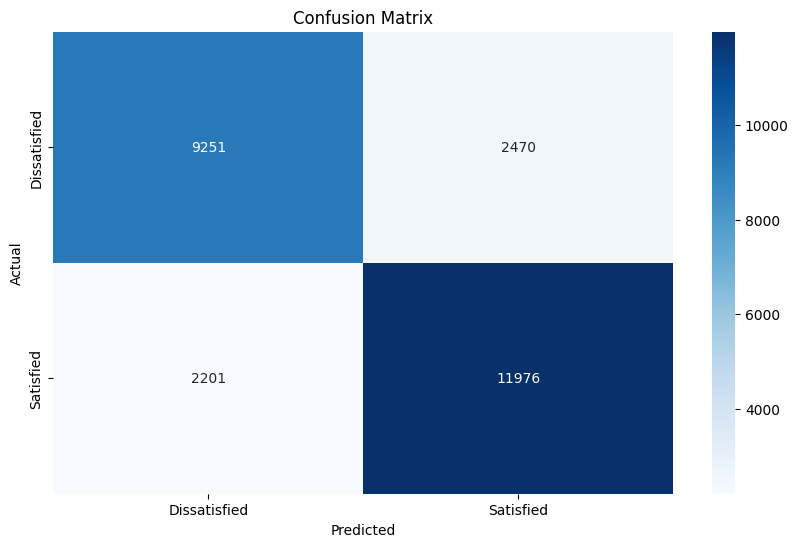

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80     11721
           1       0.83      0.84      0.84     14177

    accuracy                           0.82     25898
   macro avg       0.82      0.82      0.82     25898
weighted avg       0.82      0.82      0.82     25898



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, classification_report


model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_transformed, y_train)

y_pred = model.predict(X_test_transformed)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Dissatisfied', 'Satisfied'], yticklabels=['Dissatisfied', 'Satisfied'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


print('Classification Report:')
print(classification_report(y_test, y_pred))

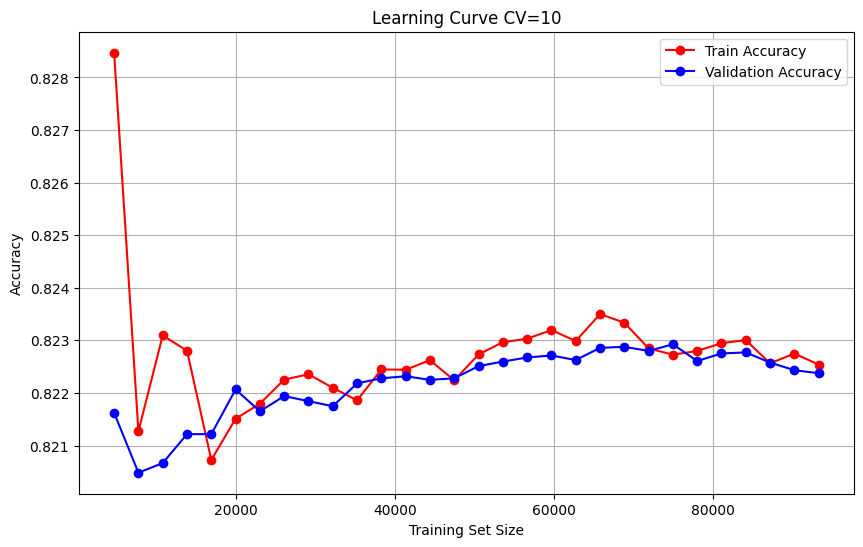

In [38]:
from sklearn.model_selection import learning_curve

train_sizes = np.linspace(0.05, 1.0, 30)

train_sizes, train_scores, test_scores = learning_curve(
    LogisticRegression(max_iter=1000), X_train_transformed, y_train,
    train_sizes=train_sizes, scoring='accuracy', cv=10
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'r-', marker='o', label='Train Accuracy')
plt.plot(train_sizes, test_mean, 'b-', marker='o', label='Validation Accuracy')

plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve CV=10")
plt.legend()
plt.grid(True)
plt.show()


Gonna add the Polynomial Features in the preprocessing

In [45]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer, RobustScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

standard_features = ['Age']
log_norm_features = ['Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
onehot_features = ['Class', 'Customer Type']
ordinal_features = ['Seat comfort', 'Inflight wifi service', 'Inflight entertainment', 'Ease of Online booking', 
                    'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']

log_transformer = Pipeline(steps=[
    ('shift', FunctionTransformer(lambda x: x - x.min() + 1, validate=True)),
    ('log', FunctionTransformer(np.log1p, validate=True)),
    ('scaler', RobustScaler()) 
])

standard_transformer = StandardScaler()
onehot_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  
ordinal_transformer = OrdinalEncoder(
    categories=[[1, 2, 3, 4, 5]] * len(ordinal_features), 
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

preprocessor = ColumnTransformer([
    ('standard', standard_transformer, standard_features),
    ('lognorm', log_transformer, log_norm_features),
    ('onehot', onehot_transformer, onehot_features),
    ('ordinal', ordinal_transformer, ordinal_features)
])

X = df_total.drop(columns=['satisfaction'])
y = df_total['satisfaction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

poly = PolynomialFeatures(degree=2, interaction_only=True) 

X_train_poly = poly.fit_transform(X_train_transformed)
X_test_poly = poly.transform(X_test_transformed)


model_base = LogisticRegression(max_iter=1000, random_state=42)
model_base.fit(X_train_transformed, y_train)
y_pred_base = model_base.predict(X_test_transformed)
f1_base = f1_score(y_test, y_pred_base)


model_poly = LogisticRegression(max_iter=1000, random_state=42)
model_poly.fit(X_train_poly, y_train)
y_pred_poly = model_poly.predict(X_test_poly)
f1_poly = f1_score(y_test, y_pred_poly)

print('Classification Report:')
print(classification_report(y_test, y_pred_poly))


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85     11721
           1       0.88      0.87      0.87     14177

    accuracy                           0.86     25898
   macro avg       0.86      0.86      0.86     25898
weighted avg       0.86      0.86      0.86     25898



In [ ]:
train_sizes = np.linspace(0.05, 1.0, 30)

train_sizes, train_scores, test_scores = learning_curve(
    LogisticRegression(max_iter=1000),
    X_train_poly, y_train,  
    train_sizes=train_sizes,
    scoring='accuracy',
    cv=10
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'r-', marker='o', label='Train Accuracy')
plt.plot(train_sizes, test_mean, 'b-', marker='o', label='Validation Accuracy')

plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve Polynomial Features (CV=10)")
plt.legend()
plt.grid(True)
plt.show()


d:\DS_work\data_science_cases\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\DS_work\data_science_cases\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-